# HW5: Dyna-Q  EXTRA

> - Full Name: **Payam Taebi**
> - Student ID: **400104867**


In [1]:
# @title Imports

# Stuff you (might) need
import random
import numpy as np
import gymnasium as gym
from tqdm.notebook import trange
from heapq import heappush, heappop
from collections import defaultdict

# Stuff used for visualization
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec

import base64
import imageio
import IPython

import seaborn as sns

In [2]:
# @title Visualization Functions

def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)


def create_policy_eval_video(env, policy, filename, Q=None, num_episodes=1):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=env.metadata['render_fps']) as video:
        for _ in range(num_episodes):
            state, info = env.reset()
            video.append_data(env.render())
            while True:
                action = policy(state, Q)
                state, reward, terminated, truncated, info = env.step(action)
                video.append_data(env.render())
                if terminated or truncated:
                    break
    return embed_mp4(filename)


def plot_rewards(rewards, average_range=None, ax=None, show=False):
    if ax is None:
        fig, ax = plt.subplots()
    xs = range(1, len(rewards) + 1)
    ax.plot(xs, rewards, marker='o', linestyle='--', label='Episode Reward')
    ax.plot(xs, np.cumsum(rewards) / xs, marker='x', label='Cumulative Average')
    ax.legend()
    ax.set(xlabel='Episodes', ylabel='Total Reward', title='Episode Rewards')
    if show:
        plt.show()


def plot_heatmap(env, value, color_terminal_states=True, ax=None, show=False):
    # Generate heatmap showing maximum value at each state
    if ax is None:
        fig, ax = plt.subplots()
    dim_x, dim_y = env.unwrapped.desc.shape
    action_max = value.argmax(axis=1)
    value_max = value.max(axis=1).reshape(dim_y, dim_x)
    act_dict = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    act_dict = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    labels = np.array([act_dict.get(action, '') for action in action_max])
    for i in range(dim_x * dim_y):
        if env.unwrapped.desc[i // dim_x, i % dim_x] == b'H':
            labels[i] = 'H'
        if env.unwrapped.desc[i // dim_x, i % dim_x] == b'G':
            labels[i] = 'G'
    labels = labels.reshape(dim_y, dim_x)
    im = sns.heatmap(value_max, cmap="RdYlGn", annot=labels, annot_kws={'fontsize': 16}, fmt='s')

    if color_terminal_states:
        for i in range(dim_x * dim_y):
            if env.unwrapped.desc[i // dim_x, i % dim_x] == b'H':
                ax.add_patch(plt.Rectangle((i % dim_x, i // dim_x), 1, 1, color='black'))
            if env.unwrapped.desc[i // dim_x, i % dim_x] == b'G':
                ax.add_patch(plt.Rectangle((i % dim_x, i // dim_x), 1, 1, color='purple'))

    ax.set(title='Maximum Value per State')
    ax.set_xticks(np.linspace(0.5, dim_x-0.5, num=dim_x))
    ax.set_xticklabels(["%d" % x for x in np.arange(dim_x)])
    ax.set_yticks(np.linspace(0.5, dim_y-0.5, num=dim_y))
    ax.set_yticklabels(["%d" % y for y in np.arange(dim_y)], rotation='horizontal')
    if show:
        plt.show()
    return im


def get_color_for_value(value, vmin, vmax):
    # Normalize the value between 0 and 1
    norm_value = (value - vmin) / (vmax - vmin)
    # Get color from a colormap
    colormap = plt.cm.RdYlGn  # You can choose any other colormap
    return colormap(norm_value)


def plot_q_values_grid(q_values, env, square_size=1, color_terminal_states=True, ax=None, show=False):
    grid = env.unwrapped.desc
    rows, cols = grid.shape
    q_values = q_values.reshape(rows, cols, 4)

    if ax is None:
      fig, ax = plt.subplots()

    # Determine the range of Q-values for normalization
    vmin = np.min(q_values)
    vmax = np.max(q_values)

    # Actions correspond to directions: 0=left, 1=right, 2=down, 3=up
    actions = {0: 'left', 2: 'right', 3: 'down', 1: 'up'}

    # Loop through each position in the grid
    for i in range(rows):
        for j in range(cols):
            # Calculate the lower-left corner of the square
            x = j * square_size
            y = i * square_size

            # Define the corners of the square
            bl = (x, y)  # bottom-left
            br = (x + square_size, y)  # bottom-right
            tl = (x, y + square_size)  # top-left
            tr = (x + square_size, y + square_size)  # top-right

            # Get Q-values for current state (i, j)
            q_left = q_values[i, j, 0]
            q_up = q_values[i, j, 1]
            q_right = q_values[i, j, 2]
            q_down = q_values[i, j, 3]

            # Check if the current cell is the one to be colored black
            if color_terminal_states and grid[i, j] == b'H':
                edge_color = None
                left_color, right_color, down_color, up_color = ['black'] * 4
            elif color_terminal_states and grid[i, j] == b'G':
                edge_color = None
                left_color, right_color, down_color, up_color = ['purple'] * 4
            else:
                edge_color = 'black'
                left_color = get_color_for_value(q_left, vmin, vmax)
                right_color = get_color_for_value(q_right, vmin, vmax)
                down_color = get_color_for_value(q_down, vmin, vmax)
                up_color = get_color_for_value(q_up, vmin, vmax)

            # Draw and color the triangles based on Q-values
            triangle_left = patches.Polygon([bl, tl, (x + square_size/2, y + square_size/2)], closed=True,
                                            edgecolor=edge_color, facecolor=left_color)
            triangle_right = patches.Polygon([br, tr, (x + square_size/2, y + square_size/2)], closed=True,
                                             edgecolor=edge_color, facecolor=right_color)
            triangle_down = patches.Polygon([bl, br, (x + square_size/2, y + square_size/2)], closed=True,
                                            edgecolor=edge_color, facecolor=down_color)
            triangle_up = patches.Polygon([tl, tr, (x + square_size/2, y + square_size/2)], closed=True,
                                          edgecolor=edge_color, facecolor=up_color)

            ax.add_patch(triangle_left)
            ax.add_patch(triangle_right)
            ax.add_patch(triangle_down)
            ax.add_patch(triangle_up)

    # Set the title
    ax.set(title='Action-State Values')

    # Set the limits of the plot
    ax.set_xlim(0, cols * square_size)
    ax.set_ylim(0, rows * square_size)

    # Set aspect of the plot to be equal
    ax.set_aspect('equal')

    # Disable ticks on both axes
    ax.set_xticks([])  # Disable x ticks
    ax.set_yticks([])  # Disable y ticks

    ax.invert_yaxis()  # Optional: Invert y-axis to have (0,0) at the top-left corner
    plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='RdYlGn'), ax=ax, label='Q-value')
    if show:
        plt.show()


def plot_performance(env, value, reward_sums):
    # Create a figure
    fig = plt.figure(figsize=(16, 12), dpi=200)

    # Define a GridSpec with 2 rows and 2 columns
    gs = GridSpec(2, 2, figure=fig)

    # Plot in the first row spanning both columns
    ax1 = fig.add_subplot(gs[0, :])
    plot_rewards(reward_sums, ax=ax1)

    # Plot in the second row
    ax2 = fig.add_subplot(gs[1, 0])
    plot_q_values_grid(value, env, ax=ax2)

    ax3 = fig.add_subplot(gs[1, 1])
    plot_heatmap(env, value, ax=ax3)

    # Show the plots
    plt.show()

In [6]:
def greedy_policy(state: int, q_values: np.ndarray) -> int:
    # Select the greedy action based on Q-values for the given state
    action = np.argmax(q_values[state])
    return action

Now define a policy that selects a greedy action with probability $1-\varepsilon$ and selects a random action with probability $\varepsilon$, for given a constant $\varepsilon$.

In [7]:
def epsilon_greedy_policy(state: int, q_values: np.ndarray, epsilon: float) -> int:
    # With probability epsilon, select a random action
    if random.random() < epsilon:
        action = env.action_space.sample()
    else:
        # Otherwise, select the greedy action based on Q-values for the given state
        action = np.argmax(q_values[state])
    return action

In [16]:
from gymnasium.envs.toy_text import FrozenLakeEnv

class CustomFrozenLakeEnv(FrozenLakeEnv):
    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)
        # Modify the reward calculation using the custom reward function
        reward = self.custom_reward_function(obs, reward, terminated)
        return obs, reward, terminated, truncated, info

    def custom_reward_function(self, observation, reward, done):
        # Compute row and column indices from the observation
        rows, cols = self.desc.shape
        row, col = divmod(observation, cols)
        tile = self.desc[row, col]

        # Define custom reward logic:
        # - Goal (G): Give a high positive reward.
        # - Hole (H): Give a high negative reward.
        # - Frozen (F): Give a small negative reward (step penalty) to encourage faster completion.
        if tile == b'G':
            custom_reward = 10.0
        elif tile == b'H':
            custom_reward = -10.0
        else:
            custom_reward = -0.1

        return custom_reward


# Extra (10 points)

If this assignment was too easy for you, feel free to implement *Prioritized Sweeping* for stochastic environments and try to learn the `8x8` Frozen Lake with `is_slippery=True`.
Use everything you've learned to achieve better results!

  0%|          | 0/200 [00:00<?, ?it/s]

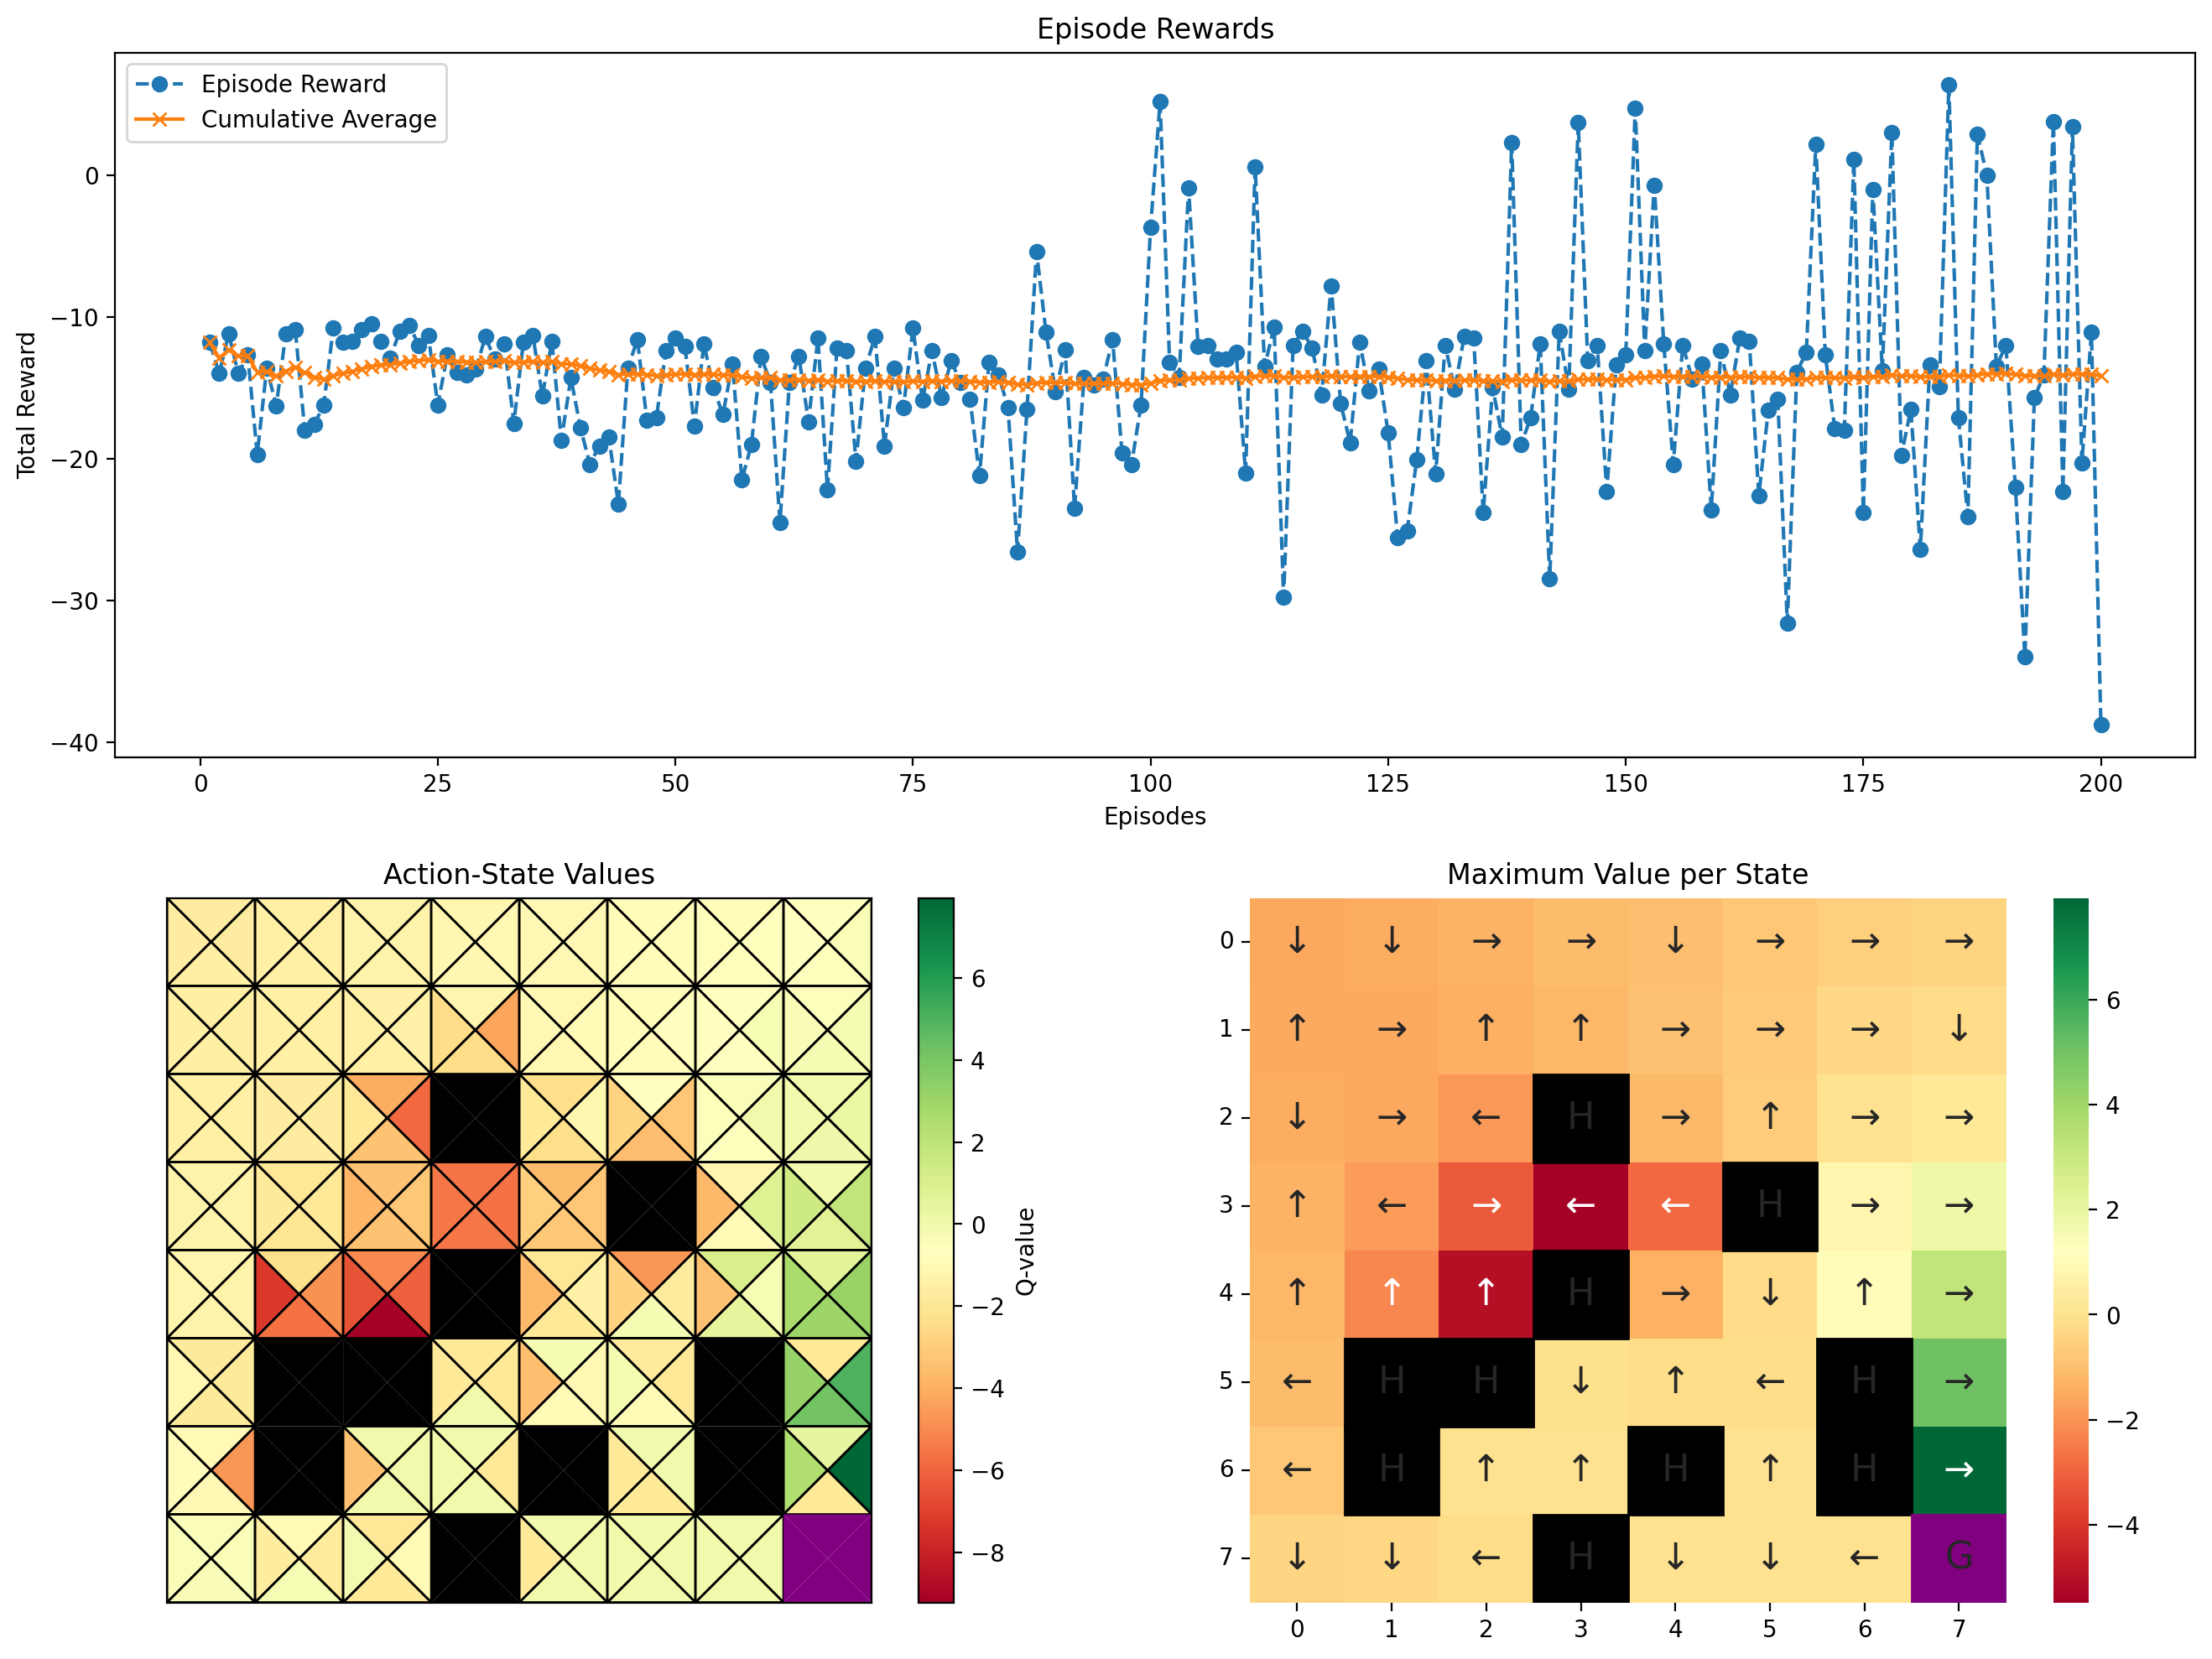

In [22]:
def q_planning_priority_stochastic(model: dict, q: np.ndarray, priorities: list, alpha: float, gamma: float, n: int, theta: float) -> np.ndarray:
    """
    Performs planning updates using Prioritized Sweeping for stochastic environments.

    Args:
        model: Dictionary mapping (state, action) pairs to a list of (reward, next_state) tuples.
        q: The Q-values array.
        priorities: A priority queue (list) storing tuples of (-priority, (state, action)).
        alpha: Learning rate.
        gamma: Discount factor.
        n: Number of planning steps.
        theta: Threshold to determine if a TD error is significant.

    Returns:
        Updated Q-values array.
    """
    for _ in range(n):
        if not priorities:
            break

        # Pop the state-action pair with the highest priority
        neg_priority, (state, action) = heappop(priorities)
        if (state, action) not in model or not model[(state, action)]:
            continue

        # For stochastic transitions, sample one transition from the list
        reward, next_state = random.choice(model[(state, action)])
        td_error = reward + gamma * np.max(q[next_state]) - q[state, action]
        q[state, action] += alpha * td_error

        # Update priorities for predecessors
        for (pred_state, pred_action), transitions in model.items():
            for (pred_reward, pred_next_state) in transitions:
                if pred_next_state == state:
                    pred_td_error = pred_reward + gamma * np.max(q[state]) - q[pred_state, pred_action]
                    if abs(pred_td_error) > theta:
                        heappush(priorities, (-abs(pred_td_error), (pred_state, pred_action)))

    return q

def dyna_q_priority_stochastic(n_episodes: int, env: gym.Env, epsilon: float, alpha: float,
                               gamma: float, n: int, theta: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Dyna-Q with Prioritized Sweeping for stochastic environments.

    The model stores lists of observed transitions for each (state, action) pair.
    A priority queue is used to schedule planning updates based on the magnitude of the TD error.

    Args:
        n_episodes: Number of episodes to run.
        env: The Gym environment.
        epsilon: Exploration rate for the epsilon-greedy policy.
        alpha: Learning rate.
        gamma: Discount factor.
        n: Number of planning steps.
        theta: Threshold to decide whether to add a state-action pair to the priority queue.

    Returns:
        A tuple of final Q-values and an array of episode reward sums.
    """
    reward_sums = np.zeros(n_episodes)
    q = np.zeros((env.observation_space.n, env.action_space.n))

    # Model for stochastic environment: maps (state, action) to a list of (reward, next_state)
    model = {}
    # Priority queue for prioritized sweeping: entries are (-priority, (state, action))
    priorities = []

    for episode_i in trange(n_episodes, leave=False):
        state, info = env.reset()
        reward_sum = 0
        terminal = False

        while not terminal:
            # Take an epsilon-greedy action
            action = epsilon_greedy_policy(state, q, epsilon)
            next_state, reward, terminated, truncated, info = env.step(action)
            terminal = terminated or truncated

            # Real experience update
            td_error = reward + gamma * np.max(q[next_state]) - q[state, action]
            q[state, action] += alpha * td_error

            # Update the model with the observed stochastic transition
            if (state, action) not in model:
                model[(state, action)] = []
            model[(state, action)].append((reward, next_state))

            # If TD error is significant, add the transition to the priority queue
            if abs(td_error) > theta:
                heappush(priorities, (-abs(td_error), (state, action)))

            # Perform planning steps with prioritized sweeping for the stochastic model
            q = q_planning_priority_stochastic(model, q, priorities, alpha, gamma, n, theta)

            state = next_state
            reward_sum += reward

        reward_sums[episode_i] = reward_sum

    return q, reward_sums
# Make sure to run the CustomFrozenLakeEnv class cell before this cell

# Set for reproducibility
np.random.seed(2025)

# Parameters for the stochastic prioritized sweeping approach
params_stochastic = {
    'epsilon': 0.1,    # epsilon for the epsilon-greedy policy
    'alpha': 0.1,      # learning rate
    'gamma': 0.99,     # discount factor
    'n': 50,           # number of planning steps
    'theta': 0.1       # threshold for adding to priority queue
}

n_episodes = 2000

# Initialize the custom environment with reward shaping for stochastic dynamics
env = CustomFrozenLakeEnv(map_name="8x8", is_slippery=True)

# Solve Frozen Lake using Dyna-Q with Prioritized Sweeping for stochastic environments
q_custom, rewards_custom = dyna_q_priority_stochastic(n_episodes, env, **params_stochastic)

# Plot the results
plot_performance(env, q_custom, rewards_custom)


In [23]:
# Evaluate the learned policy by creating a video of the agent's movement
# Use the custom environment with reward shaping in a stochastic (is_slippery=True) setting

env_video = CustomFrozenLakeEnv(map_name="8x8", render_mode="rgb_array", is_slippery=True)
video = create_policy_eval_video(env_video, greedy_policy, 'DynaQ_Stochastic', Q=q_custom)
video


### Expected Results for Prioritized Sweeping in a Stochastic Environment

- **Improved Learning Efficiency:**  
  With prioritized sweeping, planning updates focus on transitions with high TD errors. In a stochastic environment like FrozenLake with `is_slippery=True`, this means that the algorithm will concentrate its learning efforts on the most informative state-action pairs, leading to more efficient propagation of reward signals.

- **Higher Cumulative Rewards:**  
  Although the environment remains challenging due to its stochastic dynamics and sparse rewards, the combined effect of reward shaping and prioritized sweeping should gradually increase the cumulative reward over episodes. This indicates that the agent is learning to navigate the environment more reliably toward the goal.

- **Smoother Convergence:**  
  The prioritized updates are expected to result in a smoother learning curve compared to uniform sampling methods. Even if the environment's inherent randomness causes some variance in performance, the focused planning should help stabilize the learning process over time.

- **Trade-offs Due to Stochasticity:**  
  Because the environment is slippery, there might still be fluctuations in performance. However, overall, you should see better performance and a more efficient convergence than what you would obtain using a uniform planning approach or standard Dyna-Q without reward shaping.

In summary, while the stochastic nature of the environment will always pose a challenge, leveraging prioritized sweeping with a custom reward function is expected to yield higher and more stable cumulative rewards across training episodes.
